## Non-distance dependent models

This notebook contains a selection of the most important work on the non-distance dependent models.
This notebook only contains analysis on Ukraine as a whole during Euromaiden (2013/11/16 - 2014/12/31).
Analysis on just Kyiv and the entire dataset was also done and is contained in other notebooks in the Experimenting folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.optimize import fmin_l_bfgs_b

/Users/lucaswebb/.pyenv/versions/3.9.6/envs/ukraine/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [11]:
# Read in the data and remove entries older than 2013/11/16

data = pd.read_csv('2013_Events.csv')
data = data[['Event start date', 'Number of protesters']]
data['Event start date'] = pd.to_datetime(data['Event start date'])
data = data.loc[data['Event start date'] > '2013-11-15']
data = data.sort_values(by = 'Event start date')

In [12]:
# Create a column for number of events per day and then combine entries on the same day
data['Number of events'] = 0
data = data.groupby(['Event start date'], as_index=False).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})

# Convert the formatted dates into integers representing the number of each day (0 to 45) so code can be accelerated with C later
data['Event start date'] = pd.to_numeric(data['Event start date'])
data['Event start date'] = ((data['Event start date']-1384560000000000000)/86400000000000).astype(int)

Text(0.5, 1.0, 'Protest Events in Ukraine')

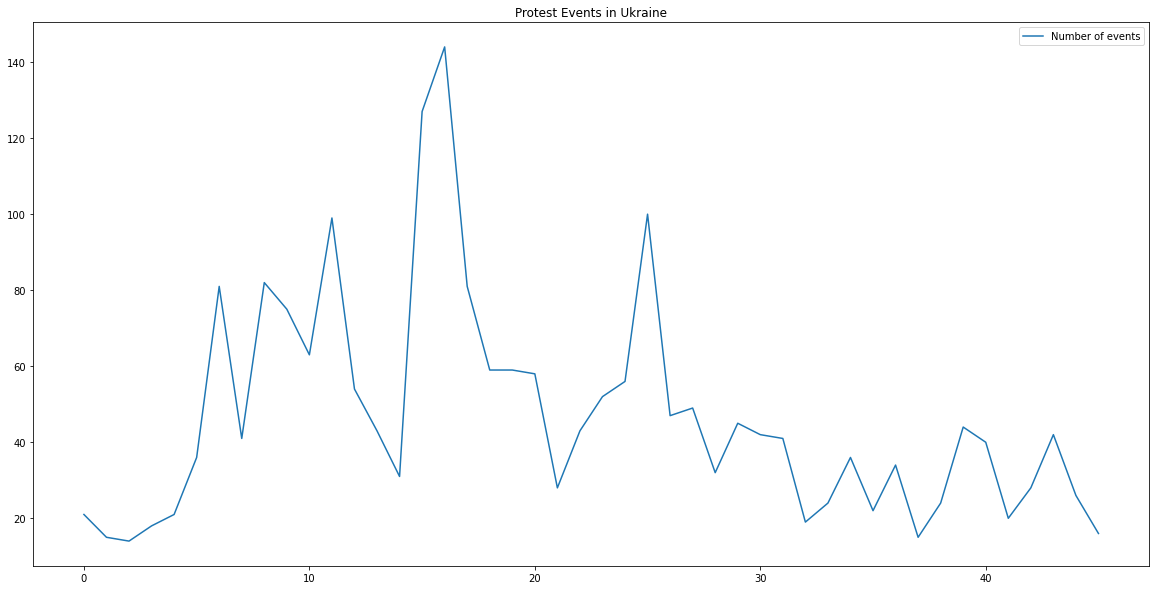

In [13]:
# Plot the number of events per day in all of Ukraine during Euromaiden

plt.figure(figsize=(20,10))
plt.plot(data['Number of events'], label='Number of events')
plt.legend()
plt.title('Protest Events in Ukraine')

In [21]:
# Add a 'simulated' and 'loss' column to the data DataFrame to store the predicted value and the cumulative likelihood
data_sim = data.copy()
data_sim['simulated'] = 0
data_sim['loss'] = 0

# Convert to a NumPy array for use with Numba
raw_data = data_sim.to_numpy()

In [26]:
raw_data[0]
# array([  0.,  21., 386.,   0.,   0.])
# (# day 0-45, # of events, # of protesters, simulated, loss)

array([  0.,  21., 386.,   0.,   0.])

In [209]:
# Define a function for both the base model and the scaled base model that calculates the poisson log-likelihood
# Use just-in-time compilation from Numba to significantly reduce execution time

# params = np.array(N_secondary, T_excite, p)
# N0 = value of the constant background
# raw = NumPy array calculated previously

# returns the poisson log-likelihood
# return_data=True returns the array of data containing the simulated value at each day
@njit
def calculateLikelihood(params, N0, raw):
    raw_copy = raw.copy()
    for i in range(0, 46):
        psum = np.array([(raw_copy[j][1]*(np.exp((-(i-raw_copy[j][0]-1))/params[1])
                                          - np.exp(-(i-raw_copy[j][0])/params[1]))) for j in range(0, i)])
        raw_copy[i][3] = params[2]*N0 + params[0] * psum.sum()
        # raw_copy[i][3] = (1-params[2])*N0 + params[2]*params[0] * psum.sum()
        if i != 0:
            raw_copy[i][4] = raw_copy[i-1][4] + (raw_copy[i][3] - (raw_copy[i][1] * np.log(raw_copy[i][3])))
        else:
            raw_copy[i][4] = (raw_copy[i][3] - (raw_copy[i][1] * np.log(raw_copy[i][3])))
        # if np.isnan(psum.sum()):
        #     print(i)
        #     print(params)
    # print(raw_copy[1149][5])
    return raw_copy[45][4]

In [210]:
# Because of C optimization must define a separate function to return the array containing the predicted values

@njit
def simulateHelper(params, N0, raw):
    raw_copy = raw.copy()
    for i in range(0, 46):
        psum = np.array([(raw_copy[j][1]*(np.exp((-(i-raw_copy[j][0]-1))/params[1])
                                          - np.exp(-(i-raw_copy[j][0])/params[1]))) for j in range(0, i)])
        raw_copy[i][3] = params[2]*N0 + params[0] * psum.sum()
        if i != 0:
            raw_copy[i][4] = raw_copy[i-1][4] + (raw_copy[i][3] - (raw_copy[i][1] * np.log(raw_copy[i][3])))
        else:
            raw_copy[i][4] = (raw_copy[i][3] - (raw_copy[i][1] * np.log(raw_copy[i][3])))
    return raw_copy

# Wrap simulateHelper into a function that returns a DataFrame instead of NumPy array
def simulate(params, N0, raw):
    sim_data = simulateHelper(params, N0, raw)
    sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Number of events':sim_data[:, 1],
                       'Number of protesters':sim_data[:, 2], 'Simulated':sim_data[:, 3], 'loss':sim_data[:, 4]})
    return sim_df

In [211]:
# Define a helper function to pass into a minimizer
def toMinimize(params):
    params = np.asarray(params)
    # Append a 1 for p if we called the function with only 2 params
    params = np.append(params, 1)
    # find real value not 12
    return calculateLikelihood(params, 3.25, raw_data)


In [261]:
res1 = fmin_l_bfgs_b(toMinimize,
                     [1, 1],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.0001, 10.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [262]:
res1

(array([0.9361165 , 1.28277565]),
 -6202.586023607442,
 {'grad': array([-0.00190994, -0.00027285]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 24,
  'nit': 5,
  'warnflag': 0})

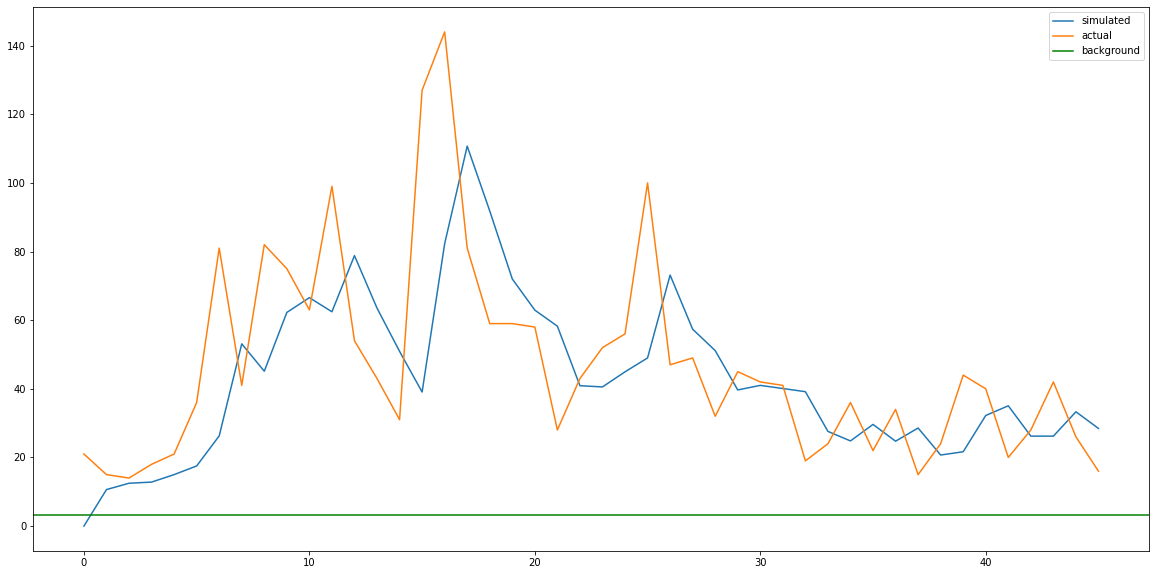

In [269]:
sim1 = simulate(res1[0], 3.25, raw_data)

plt.figure(figsize=(20,10))
plt.plot(sim1['Simulated'], label='simulated')
plt.plot(sim1['Number of events'], label='actual')
plt.axhline(y=3.25, color='g', label='background')
plt.legend()

In [265]:
res2 = fmin_l_bfgs_b(toMinimize,
                     [1, 1, 1],
                     approx_grad=True,
                     bounds=[(0.0, 10.0), (0.0001, 10.0), (0.0, 10.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [266]:
res2

(array([0.66919142, 0.94201027, 4.89294537]),
 -6236.854267004811,
 {'grad': array([-0.00436557,  0.00027285,  0.        ]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 52,
  'nit': 11,
  'warnflag': 0})

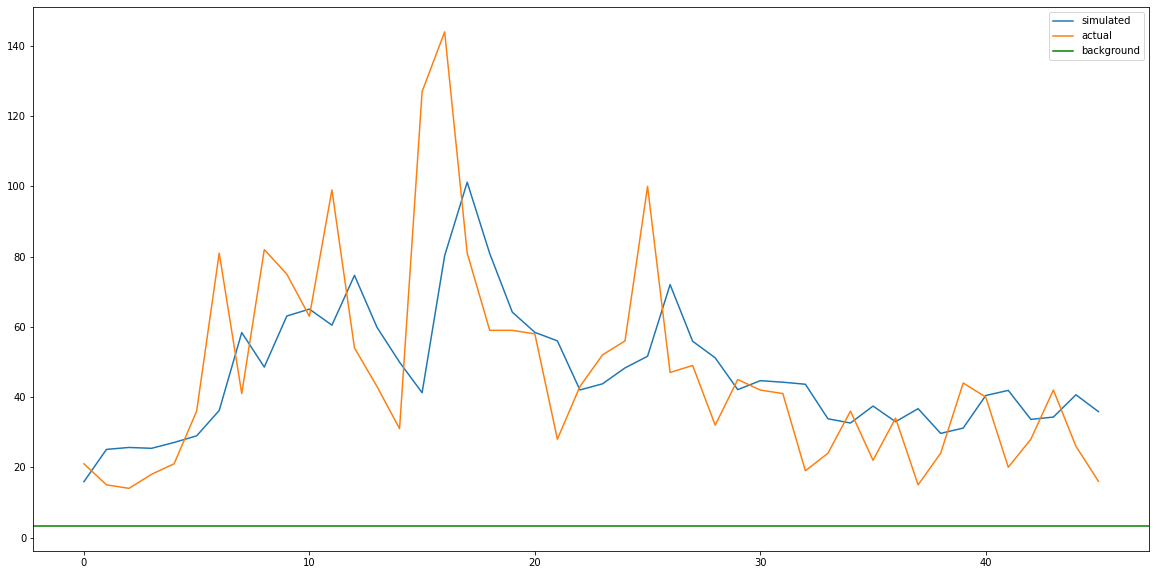

In [270]:
sim2 = simulate(res2[0], 3.25, raw_data)

plt.figure(figsize=(20,10))
plt.plot(sim2['Simulated'], label='simulated')
plt.plot(sim2['Number of events'], label='actual')
plt.axhline(y=3.25, color='g', label='background')
plt.legend()